<h1><b>Méthode : Ensemble Kalman Filter (EnKF)</b></h1>

Ce notebook présente l'utilisation du fichier `kalmanWoFost.py` pour assimiler des données

In [263]:
from kalmanWoFost import KalmanWofostDA
import numpy as np 
from pcse.models import Wofost72_WLP_FD
import datetime as dt
import pandas as pd

from dataloader import Dataloader
import os

from pcse.base import ParameterProvider
from utils import *

## 1 - Paramètres de WOFOST

Dans cette partie, on va charger les paramètres qui serviront à modéliser le champ avec Wofost.

Dans cet exemple, on va essayer de simuler le champ de notre client


In [264]:
dataloader = Dataloader("data")

# ===  1 - Crop Data ===
dataloader.printCropNames()
dataloader.printCropVarietes('potato')

cropd = dataloader.getCropData('potato', 'Innovator')
# Alternativement, vous pouvez charger un fichier
# cropd = dataloader.readCropData("POT701.CAB")



# === 2 - Paramètres du sol ===
# Chargé depuis un fichier
# 1. **EC1-Coarse**
# 2. **EC2-Medium**
# 3. **EC3-Medium Fine**
# 4. **EC4-Fine**
# 5. **EC5-Very Fine**
# 6. **EC6-Fine and Permeable (Peat)**
soild = dataloader.readSoilData("ec3.soil")

# === 3 - Paramètres du site ===
# Il s'agit des paramètres du site, indépendamment de l'espèce
#        - WAV       Initial amount of water in total soil profile [cm] <- OBLIGATOIRE
#        - IFUNRN    Indicates whether non-infiltrating fraction of rain is a function of storm size (1)
#                    or not (0). Default 0
#        - NOTINF    Maximum fraction of rain not-infiltrating into the soil [0-1], default 0.
#        - SSMAX     Maximum depth of water that can be stored on the soil surface [cm]
#        - SSI       Initial depth of water stored on the surface [cm]
#        - SMLIM     Initial maximum moisture content in initial rooting depth zone [0-1], default 0.4
sited = dataloader.getSiteData(WAV=10)


# === 4 - Agromanagement ===
agrod = dataloader.readAgromanagementData('osiris_rampe_cleaned.agro')

# === 5 - Météo ===
weatherd = dataloader.getWeatherData(lat=49.5652319502033, lon=2.4757816885380457)

# On rassemble tout
parameters = ParameterProvider(cropdata=cropd, soildata=soild, sitedata=sited)

Voici la liste des espèces disponibles :
['barley', 'cassava', 'chickpea', 'cotton', 'cowpea', 'fababean', 'groundnut', 'maize', 'millet', 'mungbean', 'pigeonpea', 'potato', 'rapeseed', 'rice', 'sorghum', 'soybean', 'sugarbeet', 'sugarcane', 'sunflower', 'sweetpotato', 'tobacco', 'wheat', 'seed_onion']
Voici la liste des variétés disponibles pour : potato
['Potato_701', 'Potato_702', 'Potato_703', 'Potato_704', 'Innovator', 'Fontane', 'Markies', 'Premiere', 'Festien']


## 2 - Simulation

On peut maintenant prédire avec WoFOST

In [265]:
wofost_noDA = getWofost_WaterLimited(parameters, weatherd, agrod)
wofost_noDA.run_till_terminate()
df_wofost_noDA = pd.DataFrame(wofost_noDA.get_output())
df_wofost_noDA = df_wofost_noDA.set_index("day")
df_wofost_noDA.tail()
#plotWofostDF(df_wofost_noDA)

,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,WWLOW
day,,,,,,,,,,,
2022-10-02,1.983857,0.0,15560.833986,12050.425653,1857.161928,1653.246405,1441.836101,0.0,50.0,0.210778,22.853864
2022-10-03,1.989233,0.0,15560.833986,12050.425653,1857.161928,1653.246405,1441.836101,0.0,50.0,0.233504,23.990159
2022-10-04,1.993524,0.0,15560.833986,12050.425653,1857.161928,1653.246405,1441.836101,0.0,50.0,0.231734,23.901671
2022-10-05,1.998490,0.0,15560.833986,12050.425653,1857.161928,1653.246405,1441.836101,0.0,50.0,0.230315,23.830729
2022-10-06,2.000000,0.0,15560.833986,12050.425653,1857.161928,1653.246405,1441.836101,0.0,50.0,0.229977,23.813845


# 3 - Observations

On va réaliser des observations pour améliorer notre simulation : c'est la data assimilation.

Dans cette partie, on va utiliser les observations du client

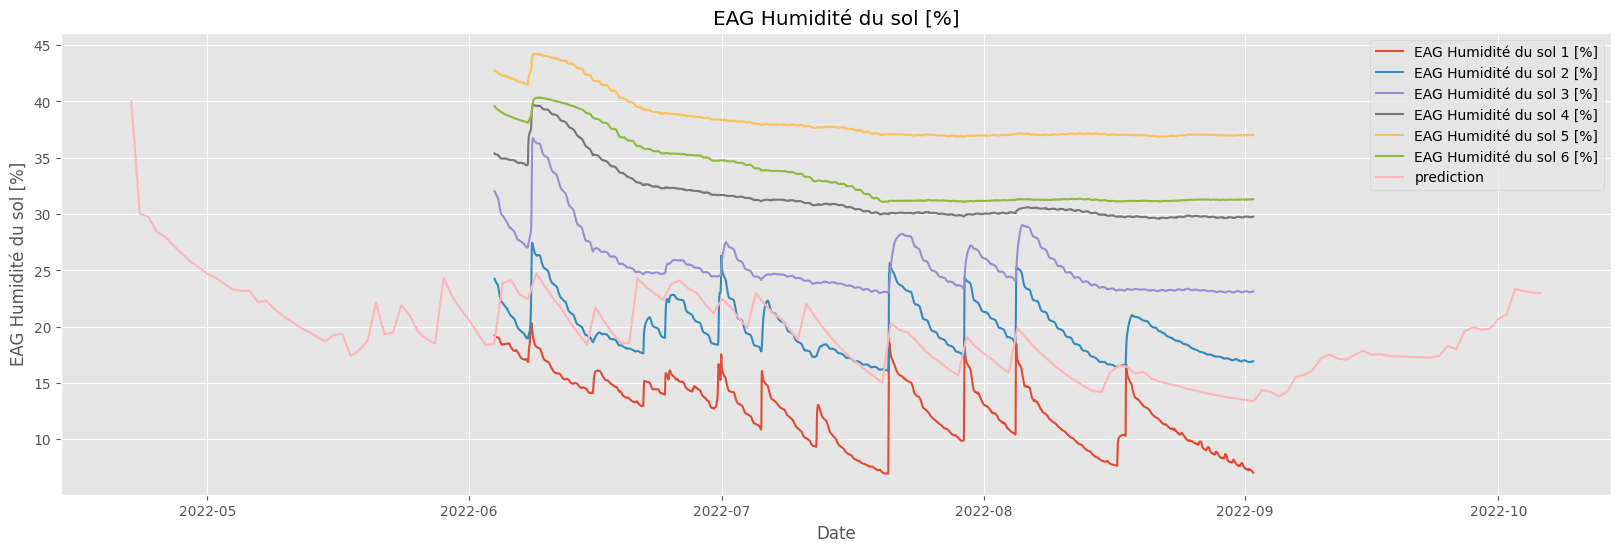

In [266]:
import matplotlib.pyplot as plt

df_obs = dataloader.readOsirisData('Sonde Rampe 1.csv')
df_obs = df_obs[df_obs['Date/heure'] < pd.Timestamp("2022-09-02")]
df_obs = df_obs[df_obs['Date/heure'] > pd.Timestamp("2022-06-04")]

plt.figure(figsize=(20, 6))

for i in range(1, 7):
    column_name = f'EAG Humidité du sol {i} [%]'
    plt.plot(df_obs['Date/heure'],df_obs[column_name], label=column_name)
    
plt.plot(df_wofost_noDA.index, df_wofost_noDA['SM']*100, label='prediction')
plt.title("EAG Humidité du sol [%]")
plt.xlabel('Date')
plt.legend()
plt.ylabel("EAG Humidité du sol [%]")
plt.grid(True)
plt.show()

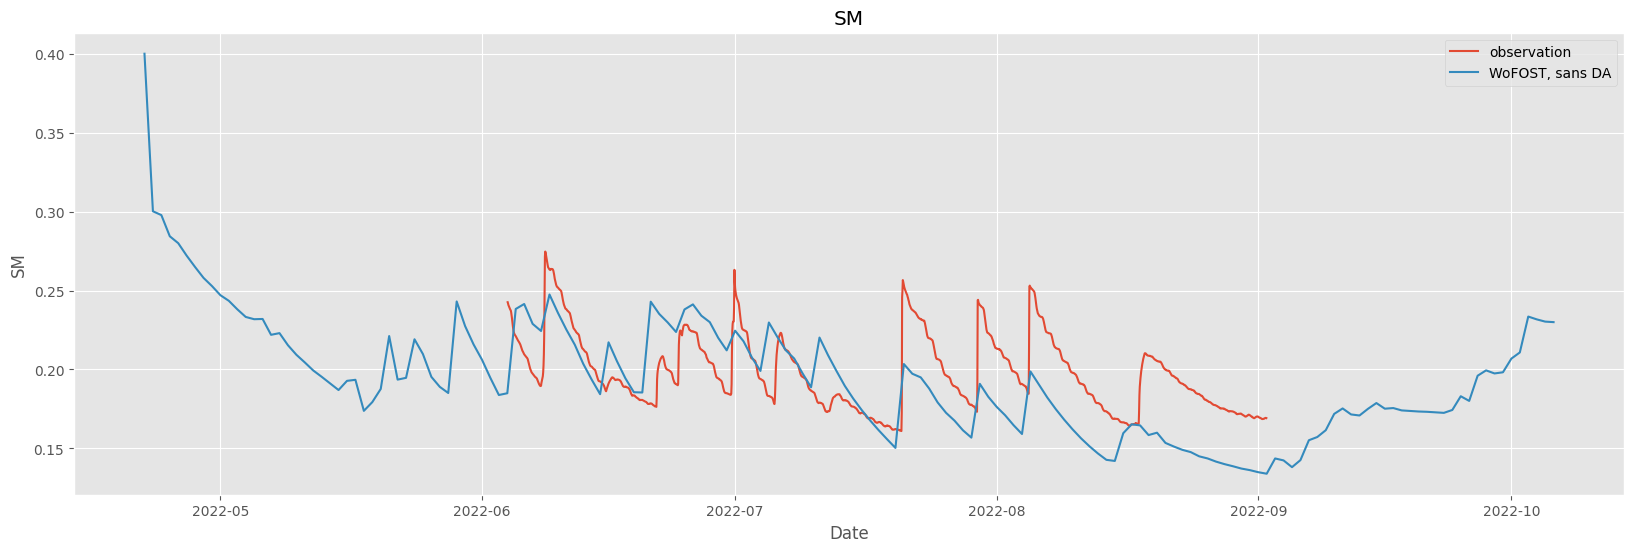

In [267]:
plt.figure(figsize=(20, 6))

plt.plot(df_obs['Date/heure'], df_obs['SM'], label = 'observation')
plt.plot(df_wofost_noDA.index, df_wofost_noDA['SM'], label='WoFOST, sans DA')
plt.title("SM")
plt.xlabel('Date')
plt.legend()
plt.ylabel("SM")
plt.grid(True)
plt.show()

Pour mesurer l'effet de la fréquence des mesures, on va échantilloner les données à notre disposition

In [268]:
NB_DAYS_DELTA = 8
dates_of_observation, observed_sm = dataloader.getOsirisSM(filename = 'Sonde Rampe 1.csv', timedelta = pd.Timedelta(NB_DAYS_DELTA, "d"), error = 0.0, begin = pd.Timestamp("2022-06-04"), end = pd.Timestamp("2022-09-02"))

observed_sm = np.array(observed_sm)
std_sm = observed_sm * 0.05 # Std. devation is estimated as 5% of observed value

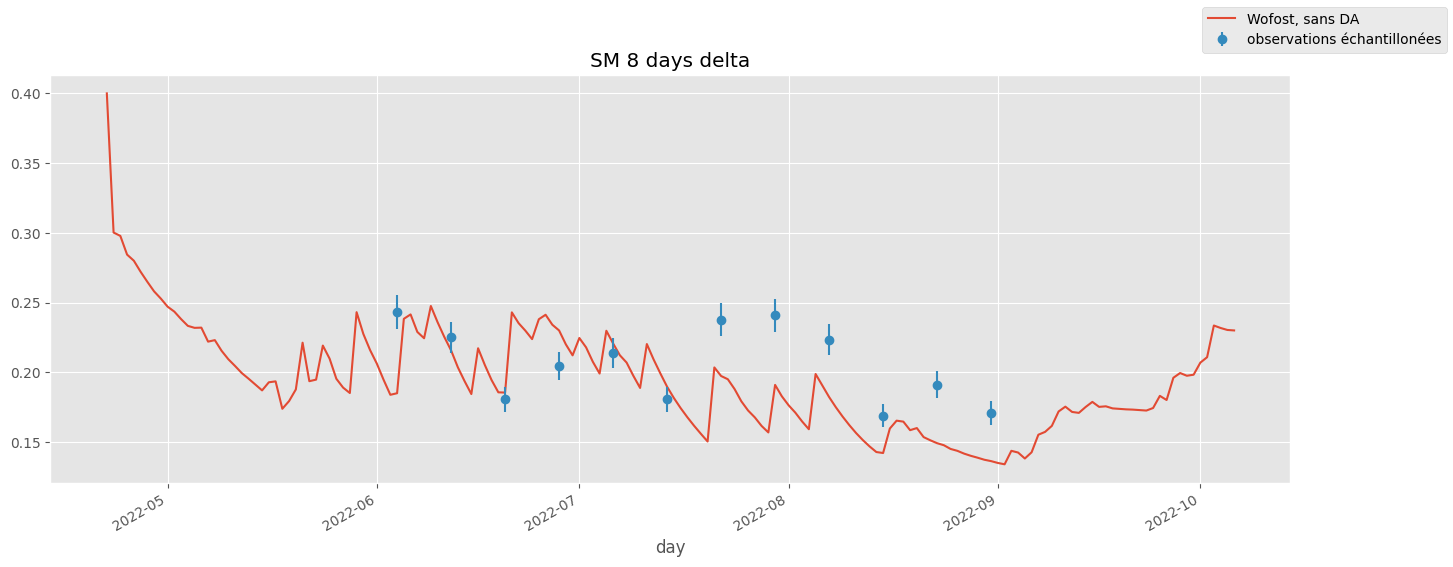

In [269]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,6), sharex=True)
df_wofost_noDA["SM"].plot(ax=axes, label="Wofost, sans DA")
axes.errorbar(dates_of_observation, observed_sm, yerr=std_sm, fmt="o", label='observations échantillonées')
axes.set_title("SM "+str(NB_DAYS_DELTA)+" days delta")
fig.autofmt_xdate()
fig.legend()

On doit maintenant tout rassembler :

In [270]:
observations_for_DA = [(d, {"SM": (sm, errsm)}) for d, sm, errsm in zip(dates_of_observation, observed_sm, std_sm)]

## 4 - EnKF

On peut maintenant utiliser l'EnKF

Il faut d'abord spécifier les paramètres sur lesquels on a un doute.

In [271]:
ensemble_size = 50
np.random.seed(10000)

print("TDWI", parameters['TDWI'])
print("WAV", parameters["WAV"])
print("SPAN", parameters["SPAN"])
print("SMFCF", parameters["SMFCF"])

TDWI 75.0
WAV 10.0
SPAN 35.0
SMFCF 0.3



On créé ensuite une zone de recherche autour des paramètres que l'on cherche à assimiler.

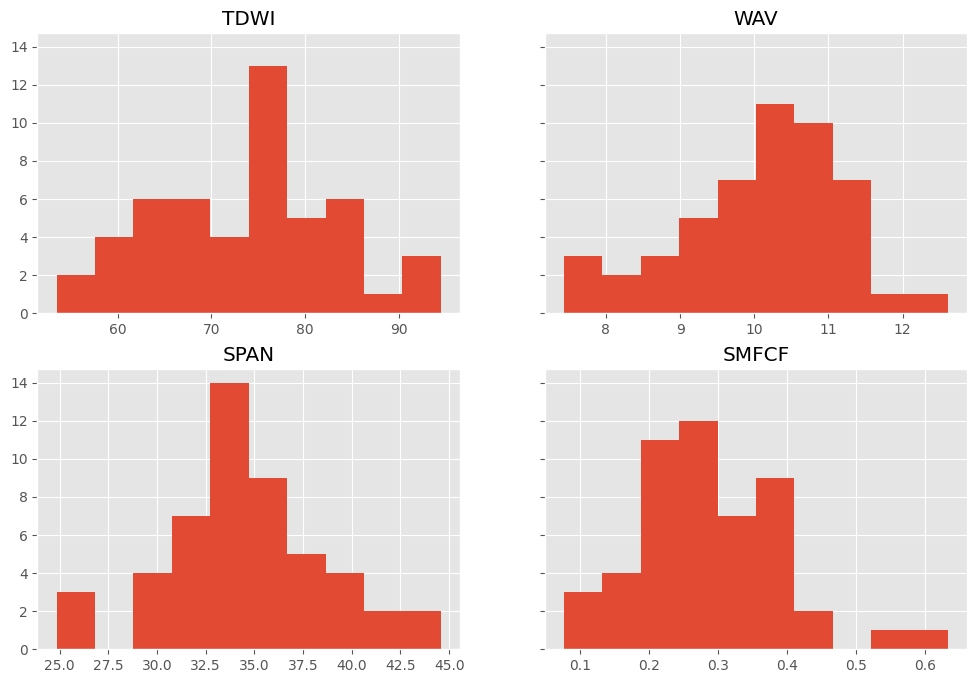

In [272]:
ensemble_size = 50

override_parameters = {}
# Initial conditions
override_parameters["TDWI"] = np.maximum(0.5, np.random.normal(parameters['TDWI'], 10, (ensemble_size)))
override_parameters["WAV"] = np.maximum(0.5, np.random.normal(parameters['WAV'], 1.0, (ensemble_size)))
# parameters
override_parameters["SPAN"] = np.maximum(0.5, np.random.normal(parameters['SPAN'], 4 ,(ensemble_size)))
override_parameters["SMFCF"] = np.maximum(0.01, np.random.normal(parameters['SMFCF'], 0.1 ,(ensemble_size)))


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8), sharey=True)
# Show the sample that was drawn
for ax, (par, distr) in zip(axes.flatten(), override_parameters.items()):
    ax.hist(distr)
    ax.set_title(par)

Finalement, on peut créer et faire tourner notre modèle:

In [273]:
kwf = KalmanWofostDA(ensemble_size, parameters, weatherd, agrod, override_parameters)
kwf.batchAssimilate(observations_for_DA)
kwf.completeSim()

[KalmanWoFoStDA] Assimilating data for {'SM': (0.24350000000000002, 0.012175000000000002)} on day 2022-06-04 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.225, 0.011250000000000001)} on day 2022-06-12 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.1807, 0.009035)} on day 2022-06-20 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.2045, 0.010225)} on day 2022-06-28 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.2139, 0.010695000000000001)} on day 2022-07-06 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.1805, 0.009025)} on day 2022-07-14 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.2378, 0.011890000000000001)} on day 2022-07-22 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.2408, 0.01204)} on day 2022-07-30 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.2234, 0.01117)} on day 2022-08-07 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.1689, 0.008445)} on day 2022-08-15 00:00:00 
[K

On peut récupérer le résultat de notre simulation

In [274]:
df_enkf_DA = kwf.getResultsWithDA()
df_enkf_NODA = kwf.getResultsNoDA()

In [275]:
df_enkf_DA.tail()

,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,WWLOW
day,,,,,,,,,,,
2022-10-02,1.983857,0.000294,15497.698802,12369.071589,1628.762186,1499.865028,1280.690803,0.000018,50.0,0.223259,23.771004
2022-10-03,1.989233,0.000175,15497.698802,12369.071589,1628.762186,1499.865028,1280.690803,0.000019,50.0,0.243592,24.794926
2022-10-04,1.993524,0.000068,15497.698802,12369.071589,1628.762186,1499.865028,1280.690803,0.000011,50.0,0.233713,24.313907
2022-10-05,1.998490,0.000068,15497.698802,12369.071589,1628.762186,1499.865028,1280.690803,0.000013,50.0,0.232294,24.242957
2022-10-06,2.000000,0.000013,15497.698802,12369.071589,1628.762186,1499.865028,1280.690803,0.000002,50.0,0.231956,24.226064


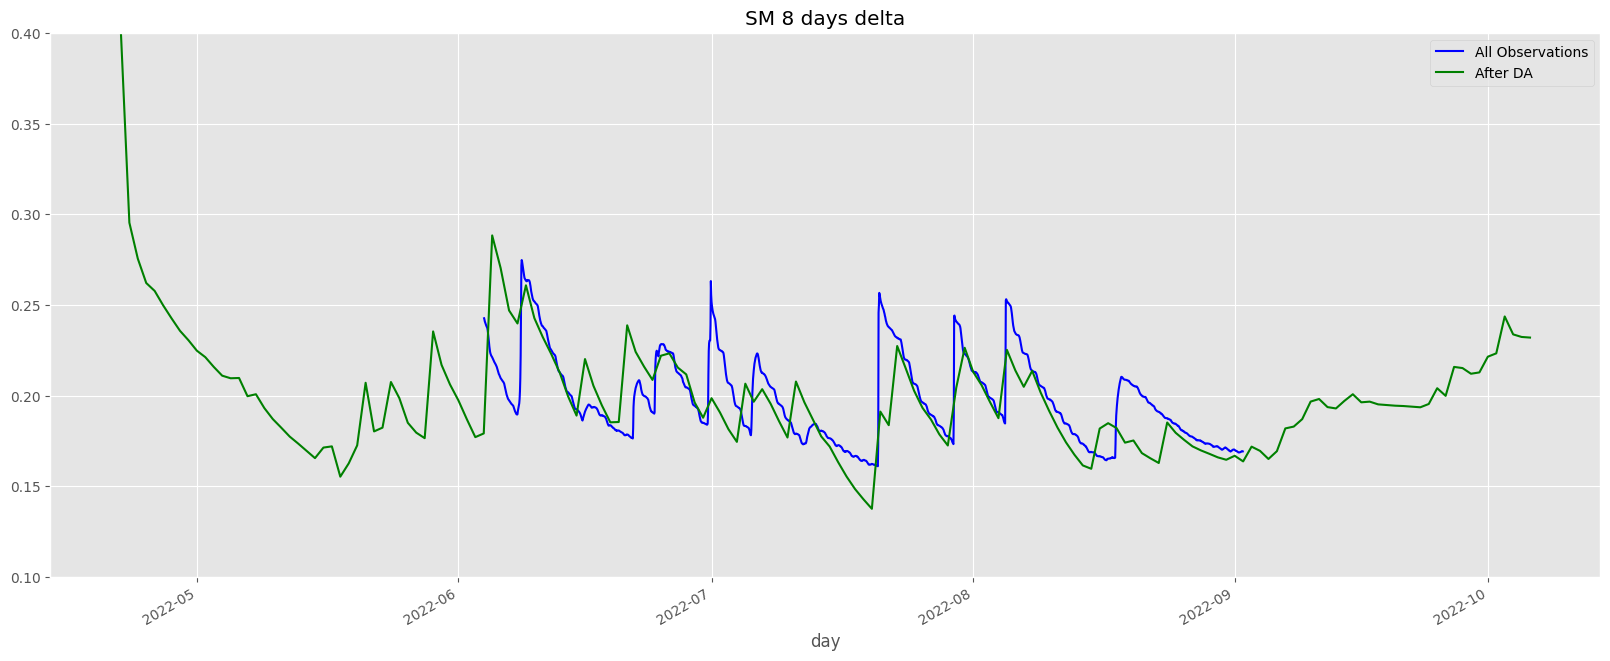

In [276]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,8), sharex=True)

axes.plot(df_obs['Date/heure'], df_obs["SM"], label="All Observations", color='b')

#df_enkf_NODA['SM'].plot(ax=axes, label="Before DA", color='r')
df_enkf_DA['SM'].plot(ax=axes, label="After DA", color='g')

#axes.errorbar(dates_of_observation, observed_sm, yerr=std_sm, fmt="x", alpha=0.8, color='gray')
axes.set_title("SM "+str(NB_DAYS_DELTA)+" days delta")
fig.autofmt_xdate()
axes.set_ylim([0.1, 0.4])

axes.legend()

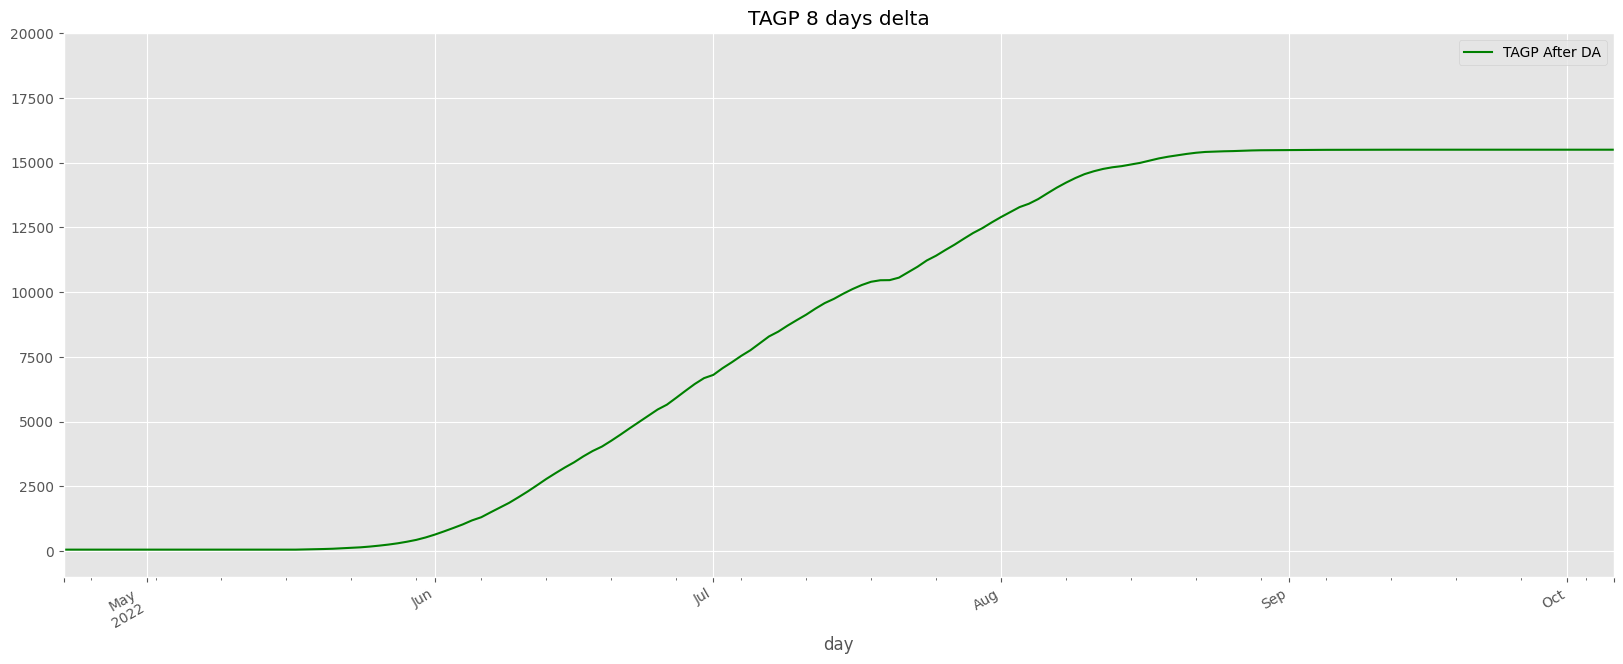

In [277]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,8), sharex=True)

df_enkf_DA['TAGP'].plot(ax=axes, label="TAGP After DA", color='g')

#axes.errorbar(dates_of_observation, observed_sm, yerr=std_sm, fmt="x", alpha=0.8, color='gray')
axes.set_title("TAGP "+str(NB_DAYS_DELTA)+" days delta")
axes.set_ylim([-1000, 20000])
fig.autofmt_xdate()

axes.legend()

In [278]:
df_enkf_DA.index

DatetimeIndex(['2022-04-22', '2022-04-23', '2022-04-24', '2022-04-25',
               '2022-04-26', '2022-04-27', '2022-04-28', '2022-04-29',
               '2022-04-30', '2022-05-01',
               ...
               '2022-09-27', '2022-09-28', '2022-09-29', '2022-09-30',
               '2022-10-01', '2022-10-02', '2022-10-03', '2022-10-04',
               '2022-10-05', '2022-10-06'],
              dtype='datetime64[ns]', name='day', length=168, freq=None)

In [279]:
df_obs_undersample = df_obs[df_obs['Date/heure'].dt.hour == 0]
minDay = str(df_obs_undersample['Date/heure'].min())
maxDay = str(df_obs_undersample['Date/heure'].max())

print(minDay, maxDay)


2022-06-05 00:00:00 2022-09-01 00:00:00


In [280]:
df_obs_undersample

,Date/heure,Précipitations [mm],EAG Humidité du sol 1 [%],EAG Humidité du sol 2 [%],EAG Humidité du sol 3 [%],EAG Humidité du sol 4 [%],EAG Humidité du sol 5 [%],EAG Humidité du sol 6 [%],Température du sol MOY 1 [°C],Température du sol MAX 1 [°C],...,Température du sol MIN 4 [°C],Température du sol MOY 5 [°C],Température du sol MAX 5 [°C],Température du sol MIN 5 [°C],Température du sol MOY 6 [°C],Température du sol MAX 6 [°C],Température du sol MIN 6 [°C],Batterie [mV],Panneau solaire [mV],SM
83,2022-06-05,0.0,18.43,22.11,29.87,34.94,42.31,38.99,18.3,18.6,...,18.0,17.1,17.2,17.1,16.5,16.6,16.5,6602,0,0.2211
107,2022-06-06,0.0,18.16,20.96,28.72,34.79,42.07,38.63,16.7,17.0,...,17.7,17.2,17.2,17.2,16.9,16.9,16.9,6648,0,0.2096
131,2022-06-07,0.0,17.46,19.73,27.65,34.54,41.74,38.38,17.5,17.9,...,17.8,17.1,17.2,17.1,16.8,16.9,16.8,6662,0,0.1973
155,2022-06-08,27.2,16.87,18.97,27.10,34.52,41.50,38.12,18.9,19.2,...,17.8,17.3,17.4,17.3,16.9,17.0,16.9,6662,0,0.1897
179,2022-06-09,0.0,18.23,26.33,36.33,39.59,44.21,40.31,15.2,15.5,...,17.3,16.9,17.0,16.9,16.9,17.0,16.9,6680,0,0.2633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2099,2022-08-28,0.0,8.82,17.50,23.20,29.75,37.03,31.26,19.4,19.8,...,20.0,19.6,19.6,19.6,19.4,19.4,19.4,6660,0,0.1750
2123,2022-08-29,0.0,8.45,17.33,23.15,29.71,37.00,31.26,19.4,19.7,...,19.6,19.2,19.3,19.2,19.2,19.2,19.2,6644,0,0.1733
2147,2022-08-30,0.0,8.09,17.19,23.15,29.73,36.98,31.28,19.7,20.0,...,19.7,19.2,19.3,19.2,19.0,19.1,19.0,6648,0,0.1719
2171,2022-08-31,0.0,7.77,17.10,23.15,29.73,37.00,31.26,21.2,21.6,...,20.0,19.3,19.4,19.3,19.2,19.2,19.2,6635,0,0.1710


In [281]:
SM_obs = df_obs_undersample['SM'].to_numpy()
SM_DA = df_enkf_DA.loc[(df_enkf_DA.index >= minDay) & (df_enkf_DA.index <= maxDay), 'SM'].to_numpy()

In [282]:
from sklearn.metrics import root_mean_squared_error

root_mean_squared_error(SM_obs, SM_DA)

0.022373623101980617

| 1d | 0.01847633509091331 |

| 2d | 0.0213640528341585

| 3d | 0.021485466365227544 |

| 4d | 0.023846332646046277 |

| 5d | 0.02395909798916903 |

| 6d | 0.02313019439906722 |

| 7d | 0.02165653528296338 |

| 8d | 0.022373623101980617 |

| 10d | 0.025831058391581837 |

| 14d | 0.025129247525136345 |

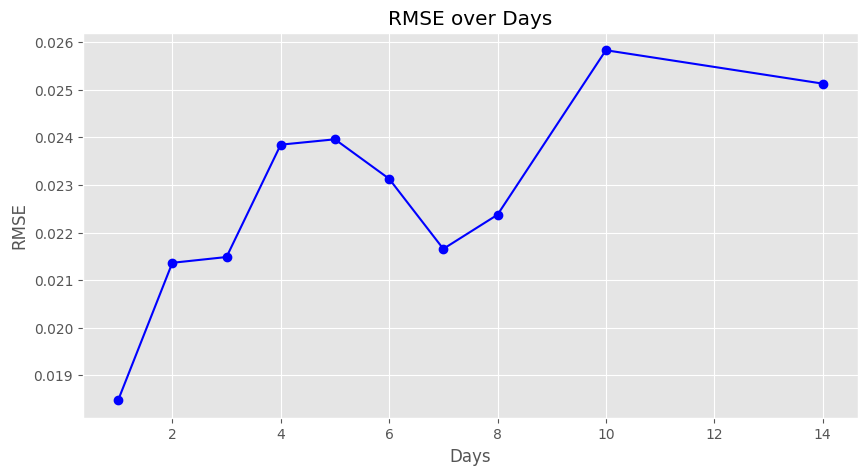

In [285]:
import matplotlib.pyplot as plt

# Data
days = [1, 2, 3, 4, 5, 6, 7, 8, 10, 14]
rmse = [0.01847633509091331, 0.0213640528341585, 0.021485466365227544, 0.023846332646046277, 
        0.02395909798916903, 0.02313019439906722, 0.02165653528296338, 0.022373623101980617, 0.025831058391581837, 
        0.025129247525136345]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(days, rmse, marker='o', linestyle='-', color='b')

# Labels and title
plt.xlabel('Days')
plt.ylabel('RMSE')
plt.title('RMSE over Days')

# Show plot
plt.grid(True)
plt.show()


In [284]:
"""
from matplotlib import pyplot as plt
fig, ax = plt.subplots(2,1)
kwf.displayLAIsM(average=True,fig=fig,axes=ax)
df_reality['LAI'].plot(style='b-', ax = ax[0])
df_reality['SM'].plot(style='b-',ax = ax[1])
"""

"\nfrom matplotlib import pyplot as plt\nfig, ax = plt.subplots(2,1)\nkwf.displayLAIsM(average=True,fig=fig,axes=ax)\ndf_reality['LAI'].plot(style='b-', ax = ax[0])\ndf_reality['SM'].plot(style='b-',ax = ax[1])\n"